In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import csv
import os
import seaborn as sns
import statsmodels.api as sm

from numpy.polynomial.polynomial import polyfit
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.utils import resample

In [11]:
#For the final working we used the datasets containing ocean temperature and salinity in various places, for the liner regression model.
# Importing original dataset with outliers included
# Data = pd.read_csv('bottle.csv')
# Y = Data[['T_degC']]
# X = Data[['Salnty']]

In [72]:
# Importing edited dataset with outliers removed
Data = pd.read_csv('bottle-NoOutliers.csv')
# Show which datapoints are being analysed
Y = Data[['T_degC']]
X = Data[['Salnty']]

In [73]:
# Test code for normalization
# X and Y data normalized to be between 0 and 1, 
# to remove influence of one variable on the final data
# Y_std = (Y - Y.min(axis=0)) / (Y.max(axis=0) - Y.min(axis=0))
# Y_scaled = Y_std * (1 - 0) + 0
# Y = Y_scaled

# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (1 - 0) + 0
# X = X_scaled

In [74]:
# Code for confidence ellipse from https://gist.github.com/CarstenSchelp/b992645537660bda692f218b562d0712

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`
    
    See how and why this works: https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html
    
    This function has made it into the matplotlib examples collection:
    https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
    
    Or, once matplotlib 3.1 has been released:
    https://matplotlib.org/gallery/index.html#statistics
    
    I update this gist according to the version there, because thanks to the matplotlib community
    the code has improved quite a bit.
    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x.T, y.T)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
    # render plot with "plt.show()".

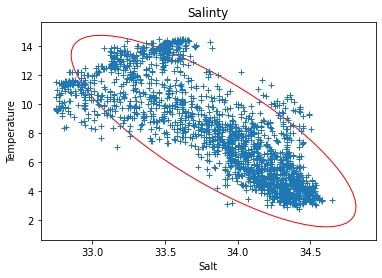

In [75]:
# The training data is plot and outliers were identified, using confidence ellipse, and removed from csv file. 
fig, ax = plt.subplots()

ax.plot(X, Y , '+')
ax.set_ylabel('Temperature')
ax.set_xlabel('Salt')
ax.set_title('Salinty');
confidence_ellipse(X , Y , ax , n_std=2, edgecolor='red')

In [76]:
# Split the dataset into testing and training data with a split of 80/20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [77]:
# Print the shape of the training data
X_train.shape, Y_train.shape

((1700, 1), (1700, 1))

In [78]:
# Print the shape of the testing data
X_test.shape, Y_test.shape

((426, 1), (426, 1))

In [79]:
model = linear_model.LinearRegression()

In [80]:
# Fit the data into the model
model.fit(X_train, Y_train)

LinearRegression()

In [86]:
# Create a linear regression model with the data and normalization performed
linear_model.LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

LinearRegression(normalize=True)

In [87]:
# Predict the outcomes based on the inputted data
Y_pred = model.predict(X_test)

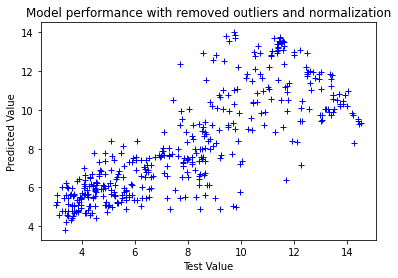

In [88]:
# Plot the predicted values against the actual values.
figure, az = plt.subplots()

az.set_ylabel('Predicted Value')
az.set_xlabel('Test Value')
az.set_title('Model performance with removed outliers and normalization');
az.plot(Y_test, Y_pred, '+', color='blue')

D:\Varun\Annaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='T_degC'>

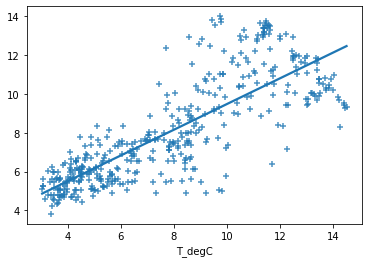

In [89]:
# Model is plotted
sns.regplot(Y_test, Y_pred, marker='+', ci=None)

In [90]:
# Print the coeefficient
print(model.coef_)
# Print the intercept
print('Intercept: ' , model.intercept_)

# Calculate and print the mean squared error
# Mean Squared error in the original data file with the outliers, was 8.71 after removing the outliers it was 3.98
# MSE with data not normalised, was 9.58 and with normalisation it was 3.68
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred))

# Calculate and print the R-squared value
# Coefficient of determination for the original data file with the outliers, was 0.41 after removing the outliers was 0.64
print('Coefficient of determination: (R^2): %.2f'
     % r2_score(Y_test, Y_pred))

[[-5.36646082]]
Intercept:  [189.75873911]
Mean squared error (MSE): 3.68
Coefficient of determination: (R^2): 0.65
